In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
)
from sklearn.model_selection import cross_val_score


In [3]:
import kagglehub
import os

path = kagglehub.dataset_download(
    "ankurzing/sentiment-analysis-for-financial-news"
)

csv_path = os.path.join(path, "all-data.csv")

df = pd.read_csv(
    csv_path,
    encoding="latin-1",
    sep=",",
    header=None,
    names=["label", "text"]
)

df["label"] = (
    df["label"]
    .astype(str)
    .str.strip()
    .str.lower()
)

label_map = {
    "positive": 0,
    "negative": 1,
    "neutral": 2
}

df["label"] = df["label"].map(label_map)


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8,
    stop_words="english"
)

X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

# Best model from Task 2 (retrained on train set)
best_model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
best_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [5]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None, zero_division=0)
recall = recall_score(y_test, y_pred, average=None, zero_division=0)
f1 = f1_score(y_test, y_pred, average=None, zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("TEST SET EVALUATION")
print("Accuracy:", accuracy)
print("Per-class Precision:", precision)
print("Per-class Recall:", recall)
print("Per-class F1:", f1)
print("Confusion Matrix:\n", cm)


TEST SET EVALUATION
Accuracy: 0.7111416781292985
Per-class Precision: [0.70247934 0.80645161 0.70782609]
Per-class Recall: [0.41666667 0.27472527 0.94212963]
Per-class F1: [0.52307692 0.40983607 0.80834161]
Confusion Matrix:
 [[ 85   4 115]
 [ 13  25  53]
 [ 23   2 407]]


In [6]:
scores = cross_val_score(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="f1_weighted"
)

print("5-Fold CV Scores:", scores)
print(f"Mean: {scores.mean():.3f} ± {scores.std():.3f}")


5-Fold CV Scores: [0.6999499  0.68458042 0.66687559 0.68788351 0.72076868]
Mean: 0.692 ± 0.018


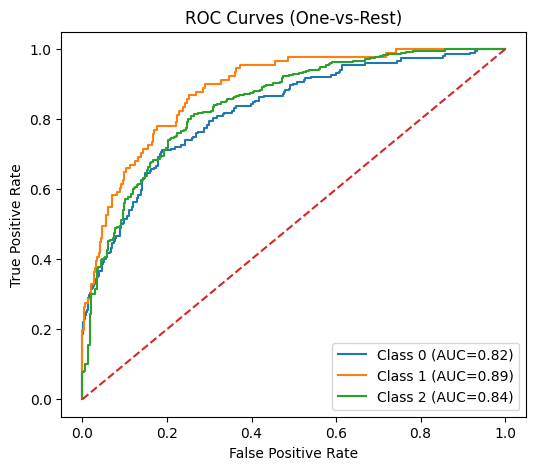

In [7]:
plt.figure(figsize=(6,5))

for cls in [0, 1, 2]:
    y_true_binary = (y_test == cls).astype(int)
    y_prob = best_model.predict_proba(X_test)[:, cls]
    
    fpr, tpr, _ = roc_curve(y_true_binary, y_prob)
    auc = roc_auc_score(y_true_binary, y_prob)
    
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.show()


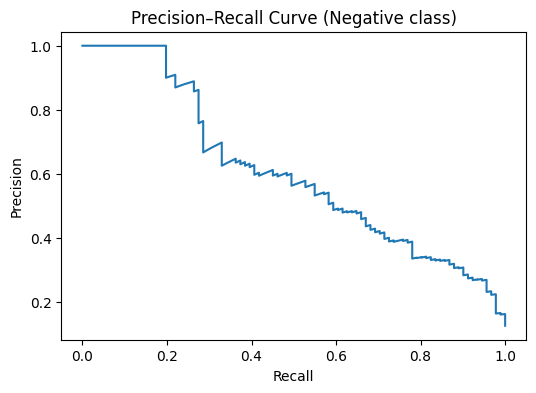

In [8]:
y_true_binary = (y_test == 1).astype(int)
y_prob = best_model.predict_proba(X_test)[:, 1]

precision_curve, recall_curve, _ = precision_recall_curve(
    y_true_binary, y_prob
)

plt.figure(figsize=(6,4))
plt.plot(recall_curve, precision_curve)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Negative class)")
plt.show()


In [9]:
probs = best_model.predict_proba(X_test)
confidence = probs.max(axis=1)

mis_idx = np.where(y_pred != y_test)[0]
top_mis = mis_idx[np.argsort(confidence[mis_idx])[::-1]][:5]

for idx in top_mis:
    print("Text:", df.iloc[idx].text)
    print("Predicted:", y_pred[idx],
          "Actual:", y_test.iloc[idx],
          "Confidence:", confidence[idx])
    print("-" * 60)


Text: The Helsinki-based company , which also owns the Salomon , Atomic and Suunto brands , said net profit rose 15 percent in the three months through Dec. 31 to (  x20ac ) 47 million ( $ 61US million ) , from (  x20ac ) 40.8 million a year earlier .
Predicted: 2 Actual: 0 Confidence: 0.8857112888246199
------------------------------------------------------------
Text: The loss for the third quarter of 2007 was EUR 0.3 mn smaller than the loss of the second quarter of 2007 .
Predicted: 2 Actual: 1 Confidence: 0.8827579370464717
------------------------------------------------------------
Text: Takoma will carry out the transaction by acquiring the entire share capital of Moventas Parkano Oy , which runs the factory in Parkano , southern Finland .
Predicted: 2 Actual: 0 Confidence: 0.8774026830065665
------------------------------------------------------------
Text: No blind-spots coming from 1 vantage point allows investigators to see the whole story in high resolution with no unbroke